# Spam Filter  

University of Amsterdam <br>
Applied Machine Learning <br>

Ayanna Colden, ayanna.colden@gamil.com <br>
Femke van Son. fvanson@live.nl

In [1]:
# to not affect python config, but only current session: 
%config IPCompleter.greedy=True

In [2]:
# Import packages

import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import pylab as pl

# data processing
from nltk.tokenize import RegexpTokenizer 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re

# models: 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.naive_bayes import BernoulliNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn import svm
from sklearn import grid_search

#Plotly for all the plots
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

# Improve the models:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import average_precision_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score



/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Processing Data


In [3]:
# extract numbers
token = RegexpTokenizer(r'\b[^\d\W]+\b') 

# remove stop words
stopwords = set(stopwords.words('english')) 

# remove subject
stopwords.update(set(['_', 'subject']))

lemmatizer = WordNetLemmatizer()

# lemmatize 
def lemmatize(data):
    for i, line in enumerate(data['text']): 
        newline = [] 
        words = line.split() 
        for word in words: 
            word = lemmatizer.lemmatize(word) 
            newline.append(word) 
        new = ' '.join(newline)  
        data.loc[i, 'text'] = new 

In [4]:
# Get data
train = pd.read_csv('./Data/emails.train.csv')
test  = pd.read_csv('./Data/emails.test.csv')

# lemmatize text
lemmatize(train)
lemmatize(test)

text = train['text']
Y_train = train['spam']
Y_test = test['spam']

# vectorize 
vectorizer = TfidfVectorizer(stop_words=stopwords, tokenizer=token.tokenize, max_features = 1000)
vectorizer.fit(text)

X_train = vectorizer.transform(train['text']).todense()
X_test = vectorizer.transform(test['text']).todense()

# Empty lists for plots 
Models = []
Scores = []
Cross_scores = []

In [5]:
# get descriptives 
plotly.tools.set_credentials_file(username='fvs10533176', api_key='r56zsrqviN0WhBa3R05F')
total_email = train.shape[0] + test.shape[0]
total_spam = train[train['spam'] == 1].shape[0] + test[test['spam'] == 1].shape[0]
total_ham =  train[train['spam'] == 0].shape[0] + test[test['spam'] == 0].shape[0]

train_spam = train[train['spam'] == 1].shape[0]
train_ham = train[train['spam'] == 0].shape[0]

test_spam = test[test['spam'] == 1].shape[0]
test_ham = test[test['spam'] == 0].shape[0]

print (train_spam)
print (test_spam)
print (train_ham)
print (test_ham)
print (total_spam)
print (total_ham)

953
415
3068
1292
1368
4360


# KNN model classifier

In [6]:
random_k = list(range(1,15))

# only odd numbers
neighbor = filter(lambda x: x % 2 != 0, random_k)

cross_scores = []

# 10 fold crossvalidation using training set, to find optimal k-value for classifier
for k in neighbor:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    cross_scores.append(scores.mean())


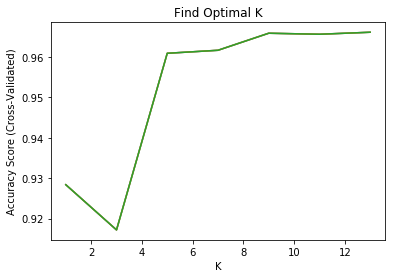

In [9]:
plt.plot(neighbor, cross_scores)
plt.ylabel("Accuracy Score (Cross-Validated)")
plt.xlabel("K")
plt.title("Find Optimal K")

plt.savefig('./Plots/knn_plot.png')

plt.show()

In [10]:
# with use of optimal_k graph
knn = KNeighborsClassifier(n_neighbors= 9)

# model fitting
knn.fit(X_train, Y_train)

# predict
Y_pred = knn.predict(X_test)

# accuracy evaluation
print accuracy_score(Y_test, Y_pred)

pd.DataFrame({
    'id': test.id,
    'spam': Y_pred
}).to_csv('./Output/knn.csv', index=False)



0.964850615114


In [11]:
Models.append('knn classifier')
Scores.append(accuracy_score(Y_test, Y_pred))
Cross_scores.append(cross_val_score(knn, X_train, Y_train, cv = 10, scoring = 'accuracy').mean())

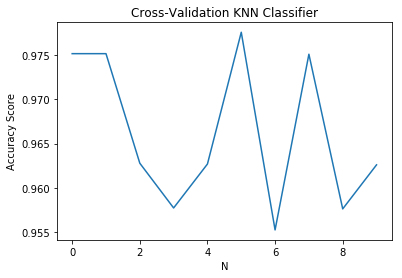

In [12]:
plt.plot(scores)
plt.ylabel("Accuracy Score")
plt.xlabel("N")
plt.title("Cross-Validation KNN Classifier")

plt.savefig('./Plots/knn_cross_plot.png')

plt.show()

# Random Forest Model Classifier

In [13]:
rf_class = RandomForestClassifier() 
 
# Use a grid search to find optimal parameters
param_grid = { 
           "n_estimators" : [8, 16, 32, 40, 48, 56],
           "max_depth" : [1, 5, 10, 15, 20, 25],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
 
CV_rf_class = GridSearchCV(estimator=rf_class, param_grid=param_grid, n_jobs=-1)
CV_rf_class.fit(X_train, Y_train)
print CV_rf_class.best_params_


{'n_estimators': 56, 'max_depth': 25, 'min_samples_leaf': 1}


In [14]:
# rf_class = RandomForestClassifier(n_estimators = 56, max_depth = 25, min_samples_leaf = 1)

estimate = CV_rf_class.best_estimator_
Y_pred = estimate.predict(X_test)

print CV_rf_class.best_score_
print accuracy_score(Y_test, Y_pred)
Models.append('Random Forest')
Scores.append(accuracy_score(Y_test, Y_pred))
Cross_scores.append(cross_val_score(rf_class, X_train, Y_train, cv = 10, scoring = 'accuracy').mean())

0.973389704054
0.968365553603


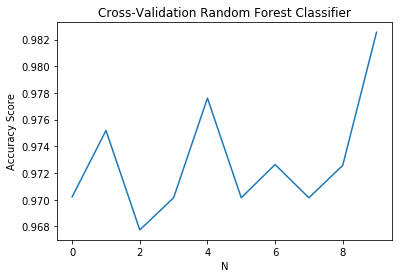

In [15]:
rf_cross = cross_val_score(rf_class, X_train, Y_train, cv = 10, scoring = 'accuracy')

plt.plot(rf_cross)
plt.ylabel("Accuracy Score")
plt.xlabel("N")
plt.title("Cross-Validation Random Forest Classifier")

plt.savefig('./Plots/rf_plot.png')

plt.show()

In [16]:
print rf_cross

[ 0.97022333  0.9751861   0.96774194  0.97014925  0.97761194  0.97014925
  0.97263682  0.97014925  0.97256858  0.98254364]


In [17]:
est = CV_rf_class.best_estimator_
Y_pred = est.predict(X_test)

pd.DataFrame({
    'id': test.id,
    'spam': Y_pred
}).to_csv('./Output/rforest.csv', index=False)

# Gaussian Process Model Classifier

In [19]:
gaus_class = GaussianProcessClassifier()

gaus_class.fit(X_train, Y_train)

Y_pred = gaus_class.predict(X_test)

print accuracy_score(Y_test, Y_pred)

Models.append('Gaussian Process')
Scores.append(accuracy_score(Y_test, Y_pred))
Cross_scores.append(cross_val_score(gaus_class, X_train, Y_train, cv = 10, scoring = 'accuracy').mean())

pd.DataFrame({
    'id': test.id,
    'spam': Y_pred
}).to_csv('./Output/gaussian.csv', index=False)


0.960749853544


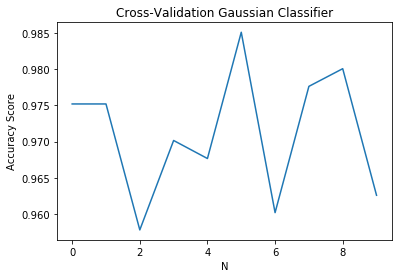

In [20]:
cross_gaus = cross_val_score(gaus_class, X_train, Y_train, cv = 10, scoring = 'accuracy')

plt.plot(cross_gaus)
plt.ylabel("Accuracy Score")
plt.xlabel("N")
plt.title("Cross-Validation Gaussian Classifier")

plt.savefig('./Plots/gaus_plot.png')

plt.show()

# Naive Bayes classifier for multivariate Bernoulli models

In [21]:
from sklearn.naive_bayes import BernoulliNB
NB = BernoulliNB()

NB.fit(X_train, Y_train)

Y_pred = NB.predict(X_test)

print (accuracy_score(Y_test, Y_pred))

Models.append('Bernoulli Naive Bayes')
Scores.append(accuracy_score(Y_test, Y_pred))
Cross_scores.append(cross_val_score(NB, X_train, Y_train, cv = 10, scoring = 'accuracy').mean())

pd.DataFrame({
    'id': test.id,
    'spam': Y_pred
}).to_csv('./Output/NB.csv', index=False)

0.932044522554


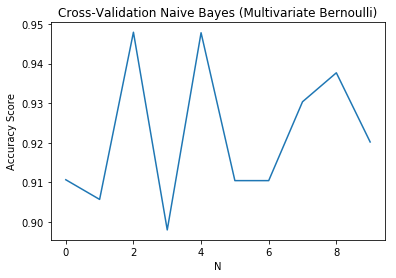

In [22]:
bayes_cross = cross_val_score(NB, X_train, Y_train, cv = 10, scoring = 'accuracy')

plt.plot(bayes_cross)
plt.ylabel("Accuracy Score")
plt.xlabel("N")
plt.title("Cross-Validation Naive Bayes (Multivariate Bernoulli)")

plt.savefig('./Plots/bayes_plot.png')

plt.show()

# C Support Vector Classification

In [23]:
#Import Library
from sklearn import svm

model = svm.SVC(kernel='rbf', C=1.0, gamma=1) 
# there is various option associated with it, like changing kernel, gamma and C value. Will discuss more # about it in next section.Train the model using the training sets and check score

model.fit(X_train, Y_train)
model.score(X_train, Y_train)
Y_pred = model.predict(X_test)

print (cross_val_score(model, X_train, Y_train, cv = 10, scoring = 'accuracy').mean())
# print (accuracy_score(Y_test, Y_pred))

Models.append('C-Support Vector')
Scores.append(accuracy_score(Y_test, Y_pred))
Cross_scores.append(cross_val_score(model, X_train, Y_train, cv = 10, scoring = 'accuracy').mean())

pd.DataFrame({
    'id': test.id,
    'spam': Y_pred
}).to_csv('./Output/C-Support.csv', index=False)


0.986575170102


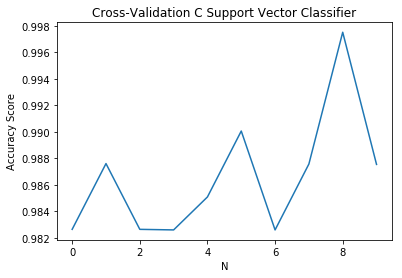

In [24]:
cross_csv = (cross_val_score(model, X_train, Y_train, cv = 10, scoring = 'accuracy'))

plt.plot(cross_csv)
plt.ylabel("Accuracy Score")
plt.xlabel("N")
plt.title("Cross-Validation C Support Vector Classifier")

plt.savefig('./Plots/csv_plot.png')

plt.show()

# Plot scores

In [32]:
fig = plt.figure(figsize=(10, 4), dpi=150)
df = pd.DataFrame()
df["scores"] = Scores
df["cross val"] = Cross_scores
df["models"] = Models


df.plot()
print df


# plt.plot(df["models"], df["scores"], 'ro')
# plt.xlabel('Method')
# plt.ylabel('Cross-Validated Accuracy')


     scores  cross val                 models
0  0.964851   0.965926         knn classifier
1  0.968366   0.968423          Random Forest
2  0.960750   0.971153       Gaussian Process
3  0.932045   0.921914  Bernoulli Naive Bayes
4  0.984183   0.986575       C-Support Vector


In [33]:
plotly.tools.set_credentials_file(username='fvs10533176', api_key='r56zsrqviN0WhBa3R05F')

trace1 = go.Bar(
    x=Models,
    y=Scores,
    name='Accuracy'
)

trace2 = go.Bar(
    x=Models,
    y= Cross_scores,
    name='Accuracy with cross validation'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    title= 'Accuracy scores for Spam detection',
    yaxis=dict(
        type='log',
        autorange=True
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Scores')


